# PSD analysis if spike data
This is based on `psd_analysis.ipynb` in this same directory. 

* 2/10/2024 setup
* 10/30/2024 update using dual plane imaging data. this is also an analysis for an R01 with YP due 11/2024.
  * Refactorings

In [1]:
import sys
import json
import matplotlib.pyplot as plt
from os.path import join, dirname
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.fftpack import fft
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.stats import t

sys.path.append("/home/gergely/code/sleep/")

from src.classes.imaging_data_class import ImagingData
from src.classes.suite2p_class import Suite2p as s2p
import src.classes.behavior_class as bc
from src import frequency_psd as fp

Mice: 
"140502_5", "140502_3", "5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"

In [2]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/dock11c5/8_2/TSeries-08022024-1036-001/TSeries-08022024-1036-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11c5/8_2/TSeries-08022024-1036-002/TSeries-08022024-1036-002.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b2/6_17/TSeries-06172024-0946-001/TSeries-06172024-0946-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b2/6_17/TSeries-06172024-0946-003/TSeries-06172024-0946-003.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/6_17/TSeries-06172024-0946-001/TSeries-06172024-0946-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/7_31/TSeries-07312024-1030-002/TSeries-07312024-1030-002.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/8_3/TSeries-08022024-1036-001/TSeries-08022024-1036-001.sima/",
    "/data2/gergely/invivo_DATA/sleep/dock11b1/8_3/TSeries-08022024-1036-002/TSeries-08022024-1036-002.sima/",
]

In [30]:
spks = []
for folder in sima_folders:
    s2p_data = s2p(join(folder, "suite2p"))
    spikes = s2p_data.get_spikes(plane=1)
    # z scoring
    n_neurons, n_time = spikes.shape
    spks.append(zscore(spikes, axis=1))

mob_immobs = []
for folder in sima_folders:
    data = join(folder, "behavior", "mobility_immobility.json")
    with open(data, "r") as f:
        mob_immobs.append(np.array(json.load(f)))

In [31]:
moving_spikes = []
immobile_spikes = []
for spk, mob_immob in zip(spks, mob_immobs):
    try:
        print(spk.shape, mob_immob.shape)

        # Check if shapes are mismatched
        if spk.shape[1] != mob_immob.shape[0]:
            # Create an interpolation function for mob_immob
            x = np.linspace(0, 1, mob_immob.shape[0])
            f = interp1d(x, mob_immob, kind="linear")

            # Create a new x array matching the spk shape and interpolate
            new_x = np.linspace(0, 1, spk.shape[1])
            mob_immob_interpolated = f(new_x)

            # Convert interpolated values to boolean if necessary
            mob_immob_interpolated = (
                mob_immob_interpolated >= 0.5
            )  # Adjust this threshold as needed
        else:
            mob_immob_interpolated = mob_immob

        moving_spikes.append(spk[:, mob_immob_interpolated == 1])
        immobile_spikes.append(spk[:, ~mob_immob_interpolated == 1])
    except ValueError as e:  # Adjust exception type if needed
        print(f"Error processing spike and mobility data: {e}")
        # Handle or log the error appropriately

(265, 20375) (20374,)
(240, 20375) (20374,)
(138, 24585) (24584,)
(122, 24585) (24584,)
(285, 24585) (24541,)
(380, 19284) (19283,)
(349, 20375) (20374,)
(344, 20375) (20374,)


In [32]:
# Initialize the dictionaries with lists to store multiple arrays
moving_data = {"freq": [], "psd": []}
notmoving_data = {"freq": [], "psd": []}

# Assuming npl.calculate_psd is your function to calculate PSD
# And assuming moving_spikes and immobile_spikes are iterables of your data arrays

for mov_data in moving_spikes:
    freq, psd = fp.calculate_psd(mov_data, 30)  # , (0, 0.1))
    moving_data["freq"].append(freq)
    moving_data["psd"].append(np.mean(psd, axis=0))

for imm_data in immobile_spikes:
    freq, psd = fp.calculate_psd(imm_data, 30)  # , (0, 0.1))
    notmoving_data["freq"].append(freq)
    notmoving_data["psd"].append(np.mean(psd, axis=0))

In [34]:
def resample_psd_to_common_freq(psd_dict, target_freqs):
    """
    Resample PSD values in a dictionary to align with a common set of frequency points.

    Parameters:
    - psd_dict: Dictionary containing "freq" and "psd" keys.
    - target_freqs: 1D numpy array of target frequency points for the resampling.

    Returns:
    - Resampled PSD values aligned with target_freqs.
    """
    resampled_psds = []

    for freq, psd in zip(psd_dict["freq"], psd_dict["psd"]):
        # Create an interpolation function based on the original freq and psd
        interp_func = interp1d(
            freq, psd, kind="linear", bounds_error=False, fill_value=0
        )
        # Use this function to calculate the PSD values at the target frequencies
        resampled_psd = interp_func(target_freqs)
        resampled_psds.append(resampled_psd)

    return np.array(resampled_psds)

In [35]:
def calculate_mean_sem(data):
    """Calculate the mean and standard error of the mean (SEM) of the data."""
    mean = np.mean(data, axis=0)
    sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    return mean, sem


def confidence_interval(data, confidence=0.95):
    """Calculate the t-distribution based confidence interval for the given data."""
    sem = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    df = data.shape[0] - 1  # Degrees of freedom
    multiplier = t.ppf((1 + confidence) / 2.0, df)
    return sem * multiplier

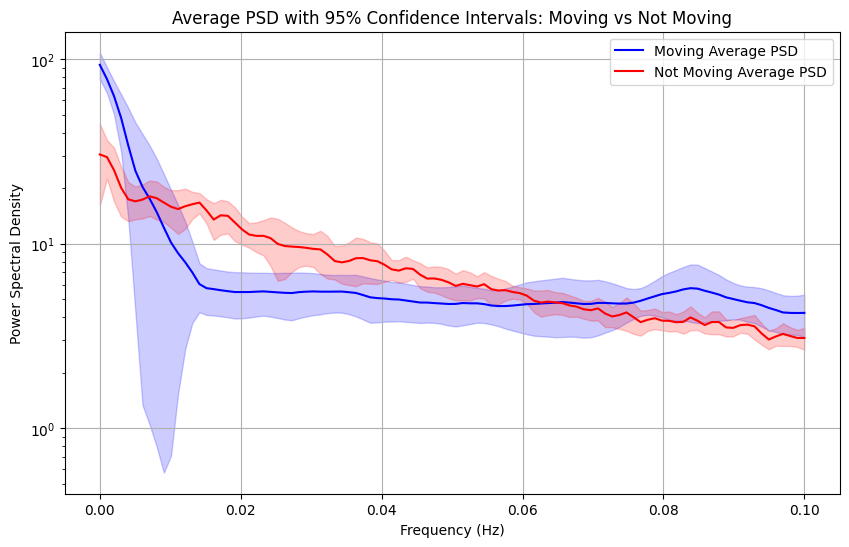

In [39]:
target_freqs = np.linspace(0, 0.1, num=100)
moving_resampled_psds = resample_psd_to_common_freq(moving_data, target_freqs)
notmoving_resampled_psds = resample_psd_to_common_freq(notmoving_data, target_freqs)
mean_moving_resampled_psd, sem_moving_resampled_psd = calculate_mean_sem(
    moving_resampled_psds
)
mean_notmoving_resampled_psd, sem_notmoving_resampled_psd = calculate_mean_sem(
    notmoving_resampled_psds
)

# Calculate the confidence interval for the mean PSD values
ci_moving_resampled_psd = confidence_interval(moving_resampled_psds)
ci_notmoving_resampled_psd = confidence_interval(notmoving_resampled_psds)

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean PSD
plt.plot(
    target_freqs, mean_moving_resampled_psd, label="Moving Average PSD", color="blue"
)
plt.plot(
    target_freqs,
    mean_notmoving_resampled_psd,
    label="Not Moving Average PSD",
    color="red",
)

# Add shaded confidence interval around the mean PSD
plt.fill_between(
    target_freqs,
    mean_moving_resampled_psd - ci_moving_resampled_psd,
    mean_moving_resampled_psd + ci_moving_resampled_psd,
    color="blue",
    alpha=0.2,
)
plt.fill_between(
    target_freqs,
    mean_notmoving_resampled_psd - ci_notmoving_resampled_psd,
    mean_notmoving_resampled_psd + ci_notmoving_resampled_psd,
    color="red",
    alpha=0.2,
)

plt.title("Average PSD with 95% Confidence Intervals: Moving vs Not Moving")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.show()